In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from math import sqrt


#calculate auprc 95% ci for each model
def auroc_ci(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mean = roc_auc
    std = sqrt(roc_auc * (1.0 - roc_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high

def auprc_ci(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    mean = pr_auc
    std = sqrt(pr_auc * (1.0 - pr_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high


import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV

data = pd.read_csv('../data/crc_folfox_mut_cna_fus_clin.csv', index_col=0)
data.head()

import datetime
today = datetime.date.today()
today_str = today.strftime('%m%d%y')
hp_date = '102123'

drug = 'folfox'
outcome = 'OS'
data_type = 'comb'
lasso_c = 2
data = pd.read_csv('../data/crc_{}_mut_cna_fus_clin.csv'.format(drug))
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
data = data.dropna(subset=[outcome])
data.reset_index(inplace=True, drop=True)

hp_res = {}
for i in range(0, 5):
    hp_res[i] = pd.read_csv(f'../results/hp_search/results_rf_lasso_folfox_OS_comb_102123_{i}.csv', index_col=0)
    hp_res[i] = hp_res[i].set_index('rank_test_score')
hp_res[0].head()

hp_res[0]['param_n_estimators'][1]
def make_rf_model(fold):
    n_estimators = hp_res[fold]['param_n_estimators'][1]
    n_estimators = int(n_estimators)
    max_depth = hp_res[fold]['param_max_depth'][1]
    max_depth = int(max_depth)
    min_samples_split = hp_res[fold]['param_min_samples_split'][1]
    min_samples_split = int(min_samples_split)
    min_samples_leaf = hp_res[fold]['param_min_samples_leaf'][1]
    min_samples_leaf = int(min_samples_leaf)
    max_features = hp_res[fold]['param_max_features'][1]
    bootstrap = hp_res[fold]['param_bootstrap'][1]
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        max_features=max_features,
                                        bootstrap=bootstrap,
                                        random_state=42)
    return rf_model
rf = make_rf_model(0)

data['rf_preds'] = np.NaN
data.head()
#create 5 train, test splits, within each train, create 5 train, valid splits
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
groups = data['id']
X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
y = data[outcome]

res_df = pd.DataFrame(columns=['fold', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auprc_mean'])
fold_count = 0
for train_index, test_index in skf.split(X, y, groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    if (data_type != 'comb') & (data_type != 'nonclin'):
        X_train = X_train[[col for col in data.columns if '{}_'.format(data_type) in col]]
        X_test = X_test[[col for col in data.columns if '{}_'.format(data_type) in col]]
    elif data_type == 'nonclin':
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
    else:
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]

    #use lasso to select features
    lasso = LogisticRegression(penalty='l1', C=lasso_c, solver='liblinear')
    lasso.fit(X_train, y_train)
    lasso_coef = lasso.coef_
    lasso_coef = lasso_coef[0]
    lasso_coef = pd.DataFrame({'feature': X_train.columns, 'coef': lasso_coef})
    lasso_coef = lasso_coef[lasso_coef['coef'] != 0]
    X_train = X_train[lasso_coef['feature']]
    X_test = X_test[lasso_coef['feature']]
    
    #print the number of mut_, cna_, and fus_ features selected
    print('fold {}'.format(fold_count))
    print('mut: {}'.format(len([col for col in X_train.columns if 'mut_' in col])))
    print('cna: {}'.format(len([col for col in X_train.columns if 'cna_' in col])))
    print('fus: {}'.format(len([col for col in X_train.columns if 'fus_' in col])))
    

    rf = make_rf_model(fold_count)
    rf.fit(X_train, y_train)

    preds = rf.predict_proba(X_train)[:,1]
    data.loc[train_index, 'rf_preds'] = preds
data.head()

2023-10-23 14:20:38.833980: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:20:38.893726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:20:38.897539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 14:20:39.779272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


fold 0
mut: 126
cna: 115
fus: 18
fold 0
mut: 124
cna: 115
fus: 20
fold 0
mut: 137
cna: 120
fus: 24
fold 0
mut: 132
cna: 122
fus: 18
fold 0
mut: 133
cna: 116
fus: 18


,id,id_institution,id_drugs_list,OS,id_tt_os_g_mos,PFS,id_tt_pfs_m_g_mos,mut_CDK4,mut_CCND3,mut_CDH1,...,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,OS_time,clin_Histology Category,clin_Histology,clin_Derived Grade or Differentiation of Tumor,clin_CEA,rf_preds
0,GENIE-DFCI-000233,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,100.986842,0.0,31.578947,0,0,0,...,2,2,0,2,3303,0,0,1,1.0,0.139707
1,GENIE-DFCI-000247,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",1,35.789474,0.0,3.914474,0,0,0,...,2,0,0,2,1163,0,0,0,4.9,0.597258
2,GENIE-DFCI-000306,DFCI,"bev, Fluorouracil, Leucovorin Calcium, Oxalipl...",0,38.125000,0.0,12.960526,0,0,0,...,2,2,0,3,1230,0,0,1,0.7,0.317683
3,GENIE-DFCI-000738,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,51.578947,NaN,NaN,0,0,0,...,0,2,0,3,1623,0,1,1,1.8,0.116961
4,GENIE-DFCI-000924,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,65.361842,NaN,NaN,0,0,0,...,0,2,1,0,2039,0,0,1,0.6,0.129978


In [3]:
data['pred_prob_quart'] = np.NaN
data['pred_prob_quart'] = pd.qcut(data['rf_preds'], 4, labels=False)
data['pred_prob_quart'].value_counts()

pred_prob_quart
0    323
3    323
1    322
2    322
Name: count, dtype: int64

In [4]:
keep = ['pred_prob_quart', 'OS_time', 'OS']

<Axes: >

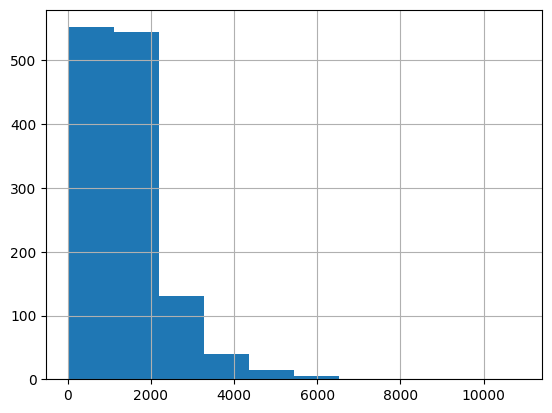

In [5]:
data['OS_time'].hist()

<Axes: >

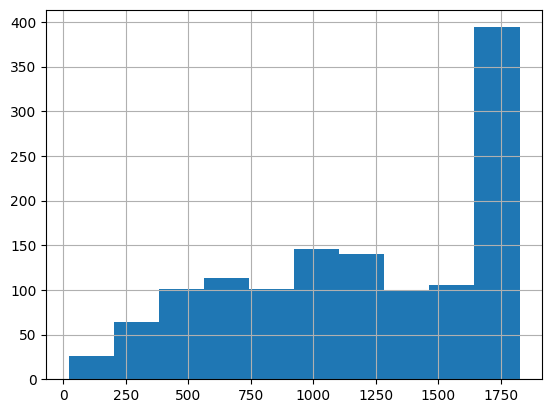

In [6]:
#limit to 5-year survival
data.loc[data['OS_time'] > 1095, 'OS_time'] = 1095
data['OS_time'].hist()

In [7]:
#get a list of time thresholds, 1-1825 days
time_thresh = [i for i in range(1, 1825)]

In [8]:
#make an empty dataframe to hold the results
km_1 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
#original number of patients
n_patients = data.shape[0]
#probability of survival
prob_survival = 1

for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data[(data['OS_time'] == t) & (data['OS'] == 0)].shape[0]
    #number of patients who died at this time point
    n_died = data[(data['OS_time'] == t) & (data['OS'] == 1)].shape[0]
    #calculate the percent of patients who died at time t, and subtract from 1 to get the probability of survival
    try:
        prob_survival = prob_survival * (1 - n_died/n_patients)
    except:
        prob_survival = 0
    perc_died = n_died/n_patients
    #add the results to the dataframe
    km_1 = pd.concat([km_1, pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_died', 'prob_survival'])], axis=0)
    #update the number of patients by removing those who died
    n_patients = n_patients - n_died
km_1.head()

,time,n_patients,n_died,prob_survival
0,1,1290,0,1.0
0,2,1290,0,1.0
0,3,1290,0,1.0
0,4,1290,0,1.0
0,5,1290,0,1.0


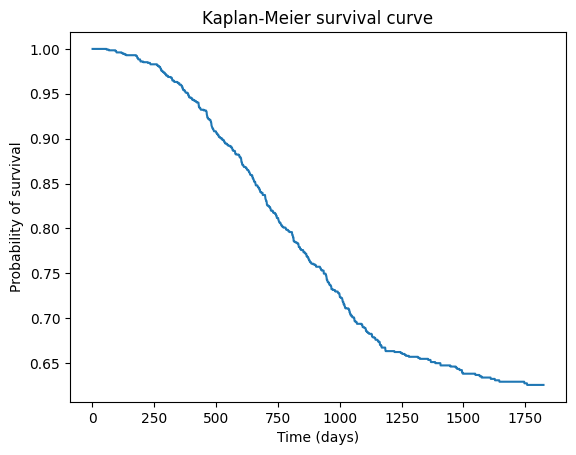

In [11]:
#plot the results
plt.plot(km_1['time'], km_1['prob_survival'])
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.title('Kaplan-Meier survival curve')
plt.show()

In [12]:
data['pred_prob_quart'].value_counts(dropna=False)

pred_prob_quart
0    323
3    323
1    322
2    322
Name: count, dtype: int64

In [13]:
data = data.dropna(subset=['pred_prob_quart'])

In [14]:
pred_quart_values = [i for i in data['pred_prob_quart'].unique() if i not in ('Stage I-III NOS', np.NaN)]

In [15]:
data_stage = {}
km_stage = {}
for stage in pred_quart_values:
    data_stage[stage] = data[data['pred_prob_quart'] == stage]
    km_stage[stage] = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
    n_patients = data_stage[stage].shape[0]
    prob_survival = 1
    for t in time_thresh:
        n_patients = n_patients - data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 0)].shape[0]
        n_died = data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 1)].shape[0]
        try:
            prob_survival = prob_survival * (1 - n_died/n_patients)
        except:
            prob_survival = 0
        try:
            perc_died = n_died/n_patients
        except:
            perc_died = 0
        km_stage[stage] = pd.concat([km_stage[stage], pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_died', 'prob_survival'])], axis=0)
        n_patients = n_patients - n_died

In [16]:
import seaborn as sns
cmap = sns.color_palette('mako', n_colors=4)
colors = {0.0: cmap[0], 1.0: cmap[1], 2.0: cmap[2], 3.0: cmap[3]}

In [17]:
km_stage.keys()

dict_keys([0, 3, 1, 2])

In [19]:
#rename the quartiles (1st, 2nd, 3rd, 4th)
km_stage[0]['quartile'] = '1st'
km_stage[1]['quartile'] = '2nd'
km_stage[2]['quartile'] = '3rd'
km_stage[3]['quartile'] = '4th'

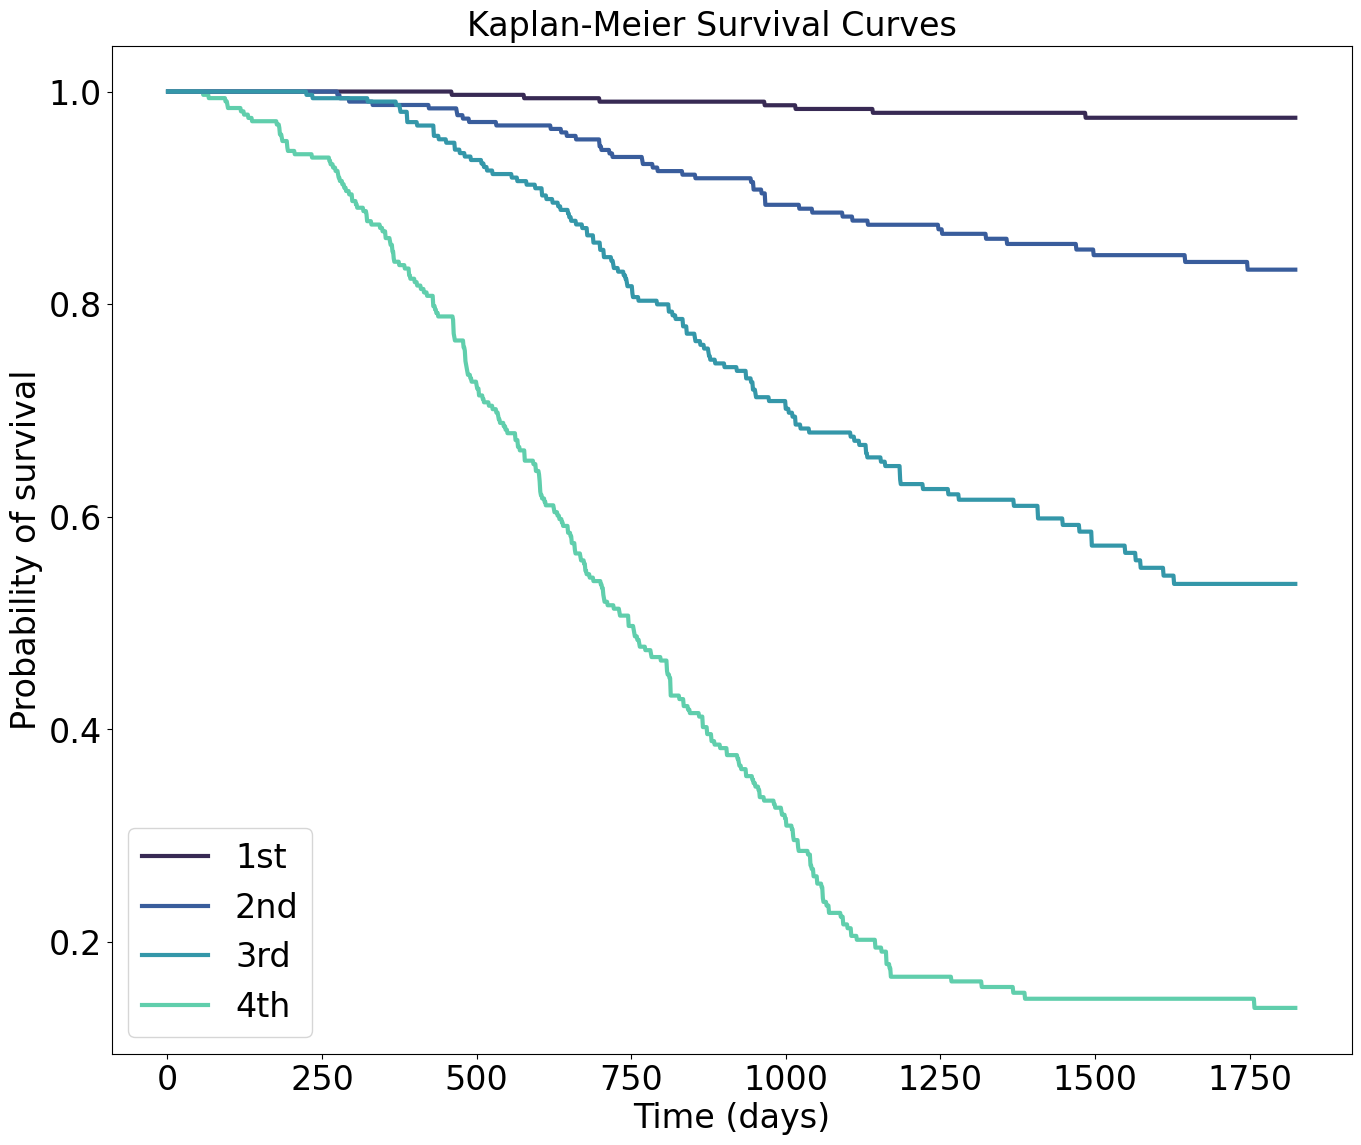

In [30]:
plt.figure(figsize=(16, 12))
for stage in km_stage.keys():
    plt.plot(km_stage[stage]['time'], km_stage[stage]['prob_survival'], label=km_stage[stage]['quartile'].unique()[0], color=colors[stage], linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
order = ['1st', '2nd', '3rd', '4th']
handles = [handles[labels.index(cat)] for cat in order]
labels = [cat for cat in order]
plt.legend(handles, labels, fontsize=24)
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.rcParams.update({'font.size': 24})
plt.suptitle('Kaplan-Meier Survival Curves', fontsize=24)
#decrease the space between the title and the figure
plt.subplots_adjust(top=0.95)
plt.savefig('../results/figures/km.png', dpi=900, bbox_inches='tight')